# Glucose-6-phosphate isomerase (PGI)

[Net reaction: g6p_c ⇌ f6p_c](http://bigg.ucsd.edu/models/iAB_RBC_283/reactions/PGI)


## Information for reconstruction
### Catalytic and regulatory mechanisms
- Catalytic mechanism:
$$\begin{align}
\text{PGI_R1}&: \text{PGI}_{c} + \text{G6P}_{c} \rightleftharpoons \text{PGI}_{c}^\mathrm{-G6P} \\
\text{PGI_R2}&: \text{PGI}_{c}^\mathrm{-G6P} \rightleftharpoons \text{PGI}_{c}^\mathrm{-F6P} \\
\text{PGI_R3}&: \text{PGI}_{c}^\mathrm{-F6P} \rightleftharpoons \text{PGI}_{c} + \text{F6P}_{c} \\
\end{align}$$

- Regulatory mechanism(s): None


### Numerical values
- Total enzyme concentration: $\text{[PGI]}_\mathrm{total} = 0.000078\ mM$
- Dissociation constants:
$$\begin{align}
K_\mathrm{d, G6P} &= 0.85\ mM \\ 
K_\mathrm{d, F6P} &= 0.117\ mM \\ 
\end{align}$$


- For the catalyzation step: $K_\mathrm{PGI} =  2.97863$

In [1]:
from os import path
from os.path import join

import matplotlib.pyplot as plt

from scipy import optimize

import sympy as sym

import pandas as pd
pd.set_option("display.max_columns", 999)

import numpy as np

from cobra import DictList

from mass.util.matrix import matrix_rank
from mass import MassMetabolite, Simulation, UnitDefinition, strip_time
from mass.enzyme_modules import EnzymeModule
from mass.io import json, sbml
from mass.util import Keq2k, k2Keq, strip_time, qcqa_model
import mass.test
from mass.test import create_test_model

from sympy import Eq, Symbol, lambdify, simplify, solveset
INF = float("inf")

In [2]:
PGI = EnzymeModule("PGI", name="Glucose-6-phosphate isomerase", subsystem="Glycolysis")

In [3]:
g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")

f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")

PGI.add_metabolites([ g6p_c, f6p_c])

PGI.enzyme_module_ligands

[<MassMetabolite g6p_c at 0x7f8fa0da8cd0>,
 <MassMetabolite f6p_c at 0x7f8fa0da8c90>]

In [4]:
PGI.enzyme_module_ligands_categorized =  {
    "substrates": [g6p_c],
    "products": [f6p_c]}
PGI.enzyme_module_ligands_categorized

for group in PGI.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

substrates: ['g6p_c']
products: ['f6p_c']


In [5]:
pgi_c = PGI.make_enzyme_module_form(
    "pgi_c",
    name="automatic",
    categories="Active",
    compartment="c")

pgi_g6p_c = PGI.make_enzyme_module_form(
    "pgi_g6p_c",
    name="automatic",
    categories="Active",
    bound_metabolites={g6p_c: 1},
    compartment="c")


pgi_f6p_c = PGI.make_enzyme_module_form(
    "pgi_f6p_c",
    name="automatic",
    categories="Active",
    bound_metabolites={f6p_c: 1},
    compartment="c")


# Print automatically generated names
for enzyme_form in PGI.enzyme_module_forms:
    print("Bound to sites of {0}:\n{1}\n".format(
        enzyme_form.id, {
            ligand.id: coeff
            for ligand, coeff in enzyme_form.bound_metabolites.items()}))
    
    
for group in PGI.enzyme_module_forms_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

Bound to sites of pgi_c:
{}

Bound to sites of pgi_g6p_c:
{'g6p_c': 1}

Bound to sites of pgi_f6p_c:
{'f6p_c': 1}

Active: ['pgi_c', 'pgi_f6p_c', 'pgi_g6p_c']


In [6]:
PGI_1 = PGI.make_enzyme_module_reaction(
    "PGI_1",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="g6p_c_binding",
    metabolites_to_add={
        "pgi_c": -1,
        "g6p_c": -1,
        "pgi_g6p_c": 1})

PGI_2 = PGI.make_enzyme_module_reaction(
    "PGI_2",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "pgi_g6p_c": -1,
        "pgi_f6p_c": 1})

PGI_3 = PGI.make_enzyme_module_reaction(
    "PGI_3",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="f6p_releasing",
    metabolites_to_add={
        "pgi_f6p_c": -1,
        "f6p_c": 1,
        "pgi_c": 1})

for reaction in PGI.enzyme_module_reactions:
    print(reaction)
    
print('\n')
for group in PGI.enzyme_module_reactions_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

PGI_1: g6p_c + pgi_c <=> pgi_g6p_c
PGI_2: pgi_g6p_c <=> pgi_f6p_c
PGI_3: pgi_f6p_c <=> f6p_c + pgi_c


g6p_c_binding: ['PGI_1']
catalyzation: ['PGI_2']
f6p_releasing: ['PGI_3']


In [7]:
PGI.update_S(array_type='DataFrame',dtype=int)
PGI.S[2:]

,PGI_1,PGI_2,PGI_3
pgi_c,-1,0,1
pgi_g6p_c,1,-1,0
pgi_f6p_c,0,1,-1


In [8]:
ode_dict = {
    enzyme_form.id: Eq(strip_time(enzyme_form.ode), 0)
    for enzyme_form in PGI.enzyme_module_forms}
# Matrix rank of enzyme stoichiometric matrix without substrates
rank = matrix_rank(PGI.S[2:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


In [9]:
enzyme_solutions = {}
for enzyme_form in PGI.enzyme_module_forms:
    # Skip dependent variable
    if enzyme_form.id == "pgi_c":
        continue
    # Get the ODE for the enzyme form from the ODE dict
    equation = ode_dict[enzyme_form.id]
    # Solve the equation for the enzyme form, substituting
    # previously found enzyme form solutions into the equation
    solution = solveset(equation.subs(enzyme_solutions),
                        enzyme_form.id)
    # Store the solution
    enzyme_solutions[enzyme_form.id] = list(solution)[0]
    # Substitute the new solution into existing solutions
    enzyme_solutions.update({
        enzyme_form: sol.subs(enzyme_solutions)
        for enzyme_form, sol in enzyme_solutions.items()})

args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))

## Define the rate constant

In [10]:
# Get the catalyzation reactions
catalyzation_group = PGI.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation")

PGI.make_enzyme_rate_equation(catalyzation_group.members,
                               use_rates=True,
                               update_enzyme=True)

print(PGI.enzyme_rate_equation)

kf_PGI_2*(Keq_PGI_2*pgi_g6p_c(t) - pgi_f6p_c(t))/Keq_PGI_2


In [11]:
enzyme_rate_equation = strip_time(PGI.enzyme_rate_error(use_values=False))
print(enzyme_rate_equation)

v_PGI - kf_PGI_2*(Keq_PGI_2*pgi_g6p_c - pgi_f6p_c)/Keq_PGI_2


In [12]:
# Solve for last unknown concentration symbolically
solution = solveset(enzyme_rate_equation.subs(enzyme_solutions),
                    "pgi_c")

# Update solution dictionary with the new solution
enzyme_solutions["pgi_c"] = list(solution)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_form: simplify(solution.subs(enzyme_solutions))
    for enzyme_form, solution in enzyme_solutions.items()}

args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))
print(args)

{v_PGI, kf_PGI_3, kf_PGI_2, kf_PGI_1, f6p_c, Keq_PGI_2, Keq_PGI_1, g6p_c, Keq_PGI_3}


In [13]:
numerical_values = {
    "Keq_PGI_1": 1/0.85,
    "Keq_PGI_2": 2.97863,
    "Keq_PGI_3": 0.117}
# Update the model with the parameters
PGI.update_parameters(numerical_values)

In [14]:
# import rbc model
from os.path import join

core_rbc = json.load_json_model(join("", "../models/RBC_RBC.json"))

In [15]:
# Get steady state flux for EnzymeModule
PGI.enzyme_rate = core_rbc.reactions.get_by_id("PGI").steady_state_flux
numerical_values[PGI.enzyme_flux_symbol_str] = PGI.enzyme_rate

# Get the ligand concentrations
for met in PGI.enzyme_module_ligands:
    concentration = core_rbc.metabolites.get_by_id(met.id).initial_condition
    # Set the ligand initial condition and add to numercal values dictionary
    met.initial_condition = concentration
    numerical_values[met.id] = concentration
    
numerical_values

{'Keq_PGI_1': 1.1764705882352942,
 'Keq_PGI_2': 2.97863,
 'Keq_PGI_3': 0.117,
 'v_PGI': 0.909963254543603,
 'g6p_c': 0.06307567680845606,
 'f6p_c': 0.025735032579299412}

## Approximate rate constant

In [16]:
enzyme_solutions = {
    enzyme_form: simplify(sol.subs(numerical_values))
    for enzyme_form, sol in enzyme_solutions.items()}

args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))
print(args)

{kf_PGI_3, kf_PGI_2, kf_PGI_1}


In [17]:
enzyme_total_error = abs(
    Symbol(PGI.enzyme_total_symbol_str)
    - strip_time(PGI.enzyme_concentration_total_equation))
print(enzyme_total_error)

Abs(-PGI_Total + pgi_c + pgi_f6p_c + pgi_g6p_c)


In [18]:
PGI.enzyme_concentration_total = 0.000078 
enzyme_total_error = enzyme_total_error.subs({
    PGI.enzyme_total_symbol_str: PGI.enzyme_concentration_total})

enzyme_total_error = simplify(enzyme_total_error.subs(enzyme_solutions))

print(enzyme_total_error)

Abs(-7.8e-5 + 1094.66554435738/kf_PGI_3 + 3257.89318654035/kf_PGI_2 + 3831.74496857154/kf_PGI_1)


In [19]:
# Sort the arguments to ensure input format remains consistent
args = sorted(list(map(str, args)))
# Use lambdify to make objective function as a lambda function
obj_fun = lambda x: lambdify(args, enzyme_total_error)(*x)

In [20]:
from scipy.optimize import minimize

# Minimize the objective function, initial guess based on publication values
initial_guess = [1e8, 1e8, 1e8]
variable_bounds = ((0, 1e9), (0, 1e9), (0, 1e9))
solution = minimize(obj_fun, x0=initial_guess,
                    method="trust-constr",
                    bounds=variable_bounds, 
                    constraints={"type": "eq", "fun": obj_fun}, 
                    options={"gtol": 1e-12, "xtol": 1e-12, "maxiter": 1e4, "disp": True})

print("\nOptimization Success: {0}".format(solution.success))

if solution.success:
    #Update the parameter values dictionary with the feasible solution
    rate_constants = dict(zip(args, solution.x))
    print("Optimization Optimality: {0:.4e}".format(solution.optimality))
    print("Parameter Solutions: {:}".format(str({arg:rate_constants[arg] for arg in args})))
    #Plug solutions back into constraints for validation
    print("Concentration Error: {0:.4e}".format(enzyme_total_error.subs(rate_constants)))
    
# Map solution array to variables
print(rate_constants)

`gtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 192, CG iterations: 46, optimality: 8.80e-13, constraint violation: 2.01e-14, execution time:  1.2 s.

Optimization Success: True
Optimization Optimality: 8.7991e-13
Parameter Solutions: {'kf_PGI_1': 104209027.064224, 'kf_PGI_2': 104921052.25848953, 'kf_PGI_3': 107538388.21597564}
Concentration Error: 2.0125e-14
{'kf_PGI_1': 104209027.064224, 'kf_PGI_2': 104921052.25848953, 'kf_PGI_3': 107538388.21597564}


In [21]:
PGI.update_parameters(rate_constants)

In [22]:
for enzyme_form, solution in enzyme_solutions.items():
    # Get the enzyme form object, determine the steady state concentration
    enzyme_form = PGI.enzyme_module_forms.get_by_id(enzyme_form)
    enzyme_form.initial_condition = float(solution.subs(rate_constants))
    print("{0}: {1:e}".format(enzyme_form.id,
                              enzyme_form.initial_condition))

pgi_g6p_c: 4.462309e-06
pgi_f6p_c: 1.326573e-05
pgi_c: 6.027196e-05


## Error value

In [23]:
print("Total Enzyme Concentration Error: {0}".format(
    PGI.enzyme_concentration_total_error(use_values=True)))

Total Enzyme Concentration Error: 2.01247701432628e-14


In [24]:
print("Enzyme Rate Error: {0}".format(
    PGI.enzyme_rate_error(use_values=True)))

Enzyme Rate Error: 1.9206858326015208e-14


## Quality Control and Assurance Check

In [25]:
qcqa_model(PGI, parameters=True, concentrations=True,
           fluxes=False, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: PGI                            │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


## Validation by adding to core_rbc

In [26]:
core_rbc_PGI = core_rbc.merge(PGI, inplace=False)
core_rbc_PGI.remove_reactions([
    core_rbc_PGI.reactions.get_by_id("PGI")])

In [27]:
core_rbc_PGI

Name,RBC_PGI
Memory address,0x07f9197e2c9d0
Stoichiometric Matrix,51x55
Matrix Rank,46
Number of metabolites,51
Initial conditions defined,51/51
Number of reactions,55
Number of genes,0
Number of enzyme modules,1
Number of groups,6
Objective expression,0


/opt/conda/lib/python3.7/site-packages/roadrunner/roadrunner.py:3944 UserWarning: Simulation requested end point (100000000.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0, 100000000.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 
/opt/conda/lib/python3.7/site-packages/roadrunner/roadrunner.py:3957 UserWarning: Simulation returned more points than max output rows specified. Try incresing the number of maximum output rows or minimum step size.


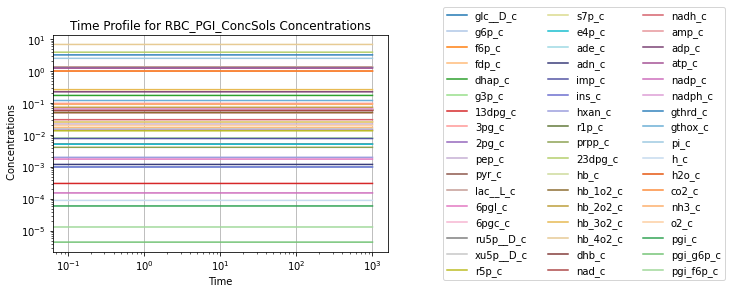

In [28]:
t0, tf = (0, 1e3)
sim_core_rbc_PGI = Simulation(core_rbc_PGI)
sim_core_rbc_PGI.find_steady_state(
    core_rbc_PGI, strategy="simulate",
    update_values=True)
conc_sol_ss, flux_sol_ss = sim_core_rbc_PGI.simulate(
    core_rbc_PGI, time=(t0, tf, tf*10 + 1))

# Quickly render and display time profiles
conc_sol_ss.view_time_profile()

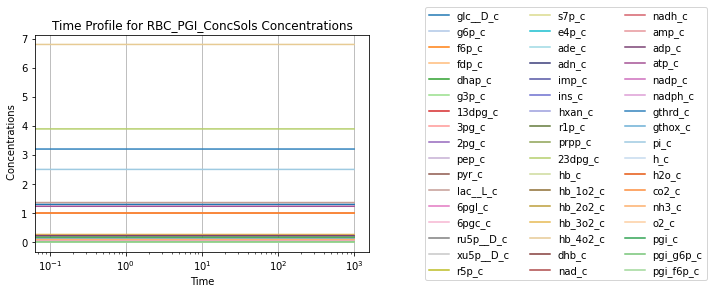

In [29]:
conc_sol_ss.view_time_profile(plot_function="semilogx")

## Export Model

In [30]:
for group in PGI.groups:
    group.id = "_".join((PGI.id, group.id))

# Export as JSON

path_to_json_model = "../models/PGI_PGI.json"
mass.io.json.save_json_model(PGI, filename=path_to_json_model)